In [1]:
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import copy
import ast
import time

np.random.seed(0)
tf.random.set_seed(0)

In [21]:
# Metrics.
def iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) for two bounding boxes.
    Box format: [x, y, width, height] where (x, y) is the center of the box.
    """
    # Convert from center coordinates (x, y, width, height) to corner coordinates (xmin, ymin, xmax, ymax)
    box1_xmin = box1[0] - box1[2] / 2
    box1_ymin = box1[1] - box1[3] / 2
    box1_xmax = box1[0] + box1[2] / 2
    box1_ymax = box1[1] + box1[3] / 2

    box2_xmin = box2[0] - box2[2] / 2
    box2_ymin = box2[1] - box2[3] / 2
    box2_xmax = box2[0] + box2[2] / 2
    box2_ymax = box2[1] + box2[3] / 2

    # Compute the coordinates of the intersection box
    inter_xmin = max(box1_xmin, box2_xmin)
    inter_ymin = max(box1_ymin, box2_ymin)
    inter_xmax = min(box1_xmax, box2_xmax)
    inter_ymax = min(box1_ymax, box2_ymax)

    # Compute area of intersection
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Compute area of both bounding boxes
    box1_area = (box1_xmax - box1_xmin) * (box1_ymax - box1_ymin)
    box2_area = (box2_xmax - box2_xmin) * (box2_ymax - box2_ymin)

    # Compute the area of union
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou_value = inter_area / union_area if union_area != 0 else 0
    return iou_value

def mean_average_precision(gt_boxes, pred_boxes, iou_threshold=0.5):
    """
    Calculate Mean Average Precision (mAP) for a list of predictions.
    gt_boxes_list: List of ground truth bounding boxes for each image (N_images, 4)
    pred_boxes_list: List of predicted bounding boxes for each image (N_images, 4)
    """

    ious = [iou(true, pred) for true, pred in zip(gt_boxes, pred_boxes)]
    # True positive if IoU is above the threshold, else false positive
    true_positives = [1 if iou_value >= iou_threshold else 0 for iou_value in ious]
    false_positives = [1 if iou_value < iou_threshold else 0 for iou_value in ious]

    # Calculate precision and recall (For simplicity, we'll calculate Precision at a single threshold)
    precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives)) if np.sum(true_positives) > 0 else 0

    return precision

In [3]:
pixel_max = 255              # max brightness in the input images, used for normalisation
input_shape = (224, 224, 3)  # Standard input size for MobileNetV2 and VGG16.
image_height_width = 224     # height and width used for MobileNetV2 and VGG16.

**Data preprocessing starts here**

In [4]:
# resize images for image net
if not os.path.exists('probe_dataset/probe_images_reshaped'):
    os.mkdir('probe_dataset/probe_images_reshaped')
    
for id in os.listdir('probe_dataset/probe_images'):
    image  = cv2.imread(f'probe_dataset/probe_images/{id}', cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, (image_height_width, image_height_width))
    three_channel_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2BGR)

    cv2.imwrite(f'probe_dataset/probe_images_reshaped/{id}', resized_image)


In [5]:
# load target info
file_path = "probe_labels.json"
with open(file_path, "r") as file:
    data = json.load(file)

# make targets array
df = pd.DataFrame.from_dict(data['annotations'])
bbox_expanded = pd.DataFrame(df["bbox"].tolist(), columns=["bbox_1", "bbox_2", "bbox_3", "bbox_4"])
df = pd.concat([df, bbox_expanded], axis=1)
targets = np.asarray(df[['bbox_1','bbox_2','bbox_3','bbox_4']])
targets_original = copy.copy(targets)

# adjust by aspect ratio from resized images
AR_X = 640/image_height_width
AR_Y = 400/image_height_width
targets[..., 0]/= AR_X
targets[..., 2]/= AR_X
targets[..., 1]/= AR_Y
targets[..., 3]/= AR_Y

# load images as np array
df_2 = pd.DataFrame.from_dict(data['images']).set_index('id')
image_ids = [df_2.loc[id]['file_name'] for id in df['image_id']]
inputs = np.asarray([cv2.imread(f'probe_dataset/probe_images_reshaped/{id}', cv2.IMREAD_COLOR) for id in image_ids])
inputs_original = np.asarray([cv2.imread(f'probe_dataset/probe_images/{id}', cv2.IMREAD_COLOR) for id in image_ids])


# Shuffle and split into train, val, test
shuffle = np.linspace(0, len(inputs)-1, len(inputs)).astype(int)
np.random.shuffle(shuffle)

inputs_tensor = tf.convert_to_tensor(inputs[shuffle].astype(np.float32), dtype=tf.float32)/pixel_max
targets_tensor = tf.convert_to_tensor(targets[shuffle].astype(np.float32), dtype=tf.float32)/image_height_width

test_proportion = 0.15
val_proportion = 0.15

total_samples = len(inputs)
test_size = int(total_samples * test_proportion)
val_size = int(total_samples * val_proportion)

test_inputs = inputs_tensor[:test_size]
test_targets = targets_tensor[:test_size]

val_inputs = inputs_tensor[test_size:test_size + val_size]
val_targets = targets_tensor[test_size:test_size + val_size]

train_inputs = inputs_tensor[test_size + val_size:]
train_targets = targets_tensor[test_size + val_size:]


# maintain original files for testing at the end, but shuffle them to avoid evaluating on the training set.
inputs_original =inputs_original[shuffle]
targets_original =targets_original[shuffle]

test_inputs_original = inputs_original[:test_size]
test_targets_original = targets_original[:test_size]

val_inputs_original = inputs_original[test_size:test_size + val_size]
val_targets_original = targets_original[test_size:test_size + val_size]

train_inputs_original = inputs_original[test_size + val_size:]
train_targets_original = targets_original[test_size + val_size:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


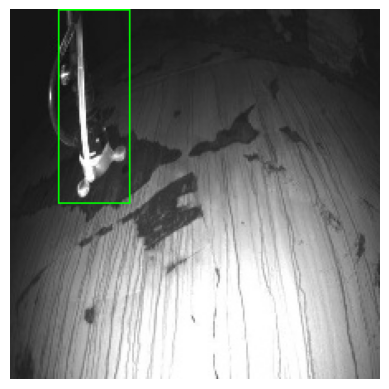

In [8]:
# manually check that the bounding boxes are still in the right places and the pictures still look like pictures

color = (0, 255, 0)
thickness = 1  # Thickness of the box border

# Manually check if it's right, loop through as many as you want
for number in range(1):
    # Coordinates for the bounding box (start and end points)
    target = np.asarray(targets_tensor[number])*image_height_width

    start_point = (int(target[0]), int(target[1]))
    end_point = (int(target[0]) + int(target[2]), int(target[1]) + int(target[3]))

    # Check if the image is grayscale (1 channel) or color (3 channels)
    image = np.asarray(inputs_tensor).copy()[number]  # Get the image

    # If the image is grayscale, convert it to BGR
    if len(image.shape) == 2:  # Grayscale image
        image_with_box = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_with_box = image.copy()  # If it's already in color, no need to convert

    # Draw a colored rectangle (e.g., Red color with thickness 2)
    image_with_box = cv2.rectangle(image_with_box, start_point, end_point, color, thickness)

    # Display the image with the box using Matplotlib
    plt.imshow(image_with_box)
    plt.axis("off")
    plt.show()


**Model preparation and tuning starts here**

In [7]:
def build_model(input_shape, dropout_percent, base_model_type, dense_units_list, output_activation, learning_rate):
    """
    Function to build the model based on hyperparameters.
    
    Parameters:
    - input_shape: Shape of the input images (height, width, channels).
    - dropout_percent: Dropout percentage.
    - base_model_type: 'mobilenetv2' or 'vgg16' for the base model.
    - dense_units_list: List of integers representing the number of units in the dense layers.
    - output_activation: Activation function for output ('sigmoid' or 'linear').
    - learningrate: Learning rate.
    
    Returns:
    - A compiled Keras model.
    """
    
    # Load the base model (MobileNetV2 or VGG16) based on hyperparameter selection
    if base_model_type == 'mobilenetv2':
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                       include_top=False,
                                                       weights='imagenet')
    elif base_model_type == 'vgg16':
        base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet')
    else:
        raise ValueError("Invalid base model type. Choose 'mobilenetv2' or 'vgg16'.")

    # Freeze the base model to avoid training its weights
    base_model.trainable = False
    
    # Build the model
    input_layer = tf.keras.Input(shape=input_shape)  # Input layer
    x = base_model(input_layer, training=False)  # Base model
    x = layers.Dropout(dropout_percent)(x)  # Dropout after base model
    x = layers.Flatten()(x)  # Flatten the output
    
    # Add dense layers with units from dense_units_list
    for units in dense_units_list:
        x = layers.Dropout(dropout_percent)(x)
        x = layers.Dense(units, activation="relu")(x)
    
    # Output layer with the specified number of output units and activation function
    outputs = layers.Dense(4, activation=output_activation)(x)
    
    # Define the model
    model = models.Model(input_layer, outputs)
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()]
                ) 

    return model

def compute_outputs(model, inputs):
    '''
    Compute the model predictions for a 224 x 224 image.
    '''
    output = np.asarray(model(inputs))
    output = output*image_height_width
    output[output>image_height_width] = image_height_width
    output[output<0] = 0
    return output

def convert_prediction(prediction, AR_X = 640/image_height_width , AR_Y = 400/image_height_width):
    ''' 
    Adjust the predictions for a 660x400 image
    '''
    prediction[..., 0]*= AR_X
    prediction[..., 2]*= AR_X
    prediction[..., 1]*= AR_Y
    prediction[..., 3]*= AR_Y

    return prediction


In [8]:
# generate file for hyper parameters
init = False # make sure you don't accidentally delete the one that's there.
if init:
    hyperparams = []
    for base_model_type in ['mobilenetv2', 'vgg16']:
        for dense_units_list in [[128, 64, 32], [32, 16]]:
            for dropout_percent in [0.2, 0]:
                for output_activation in ['linear', 'sigmoid']:
                    for learning_rate in [0.001, 0.0001]:
                        for batch_size in [32,16]:
                            hyperparams.append([base_model_type, dense_units_list, dropout_percent, output_activation, learning_rate, batch_size])
    hyperparams = pd.DataFrame(data=hyperparams, columns = ['base_model_type', 'dense_units_list', 'dropout_percent', 'output_activation', 'learning_rate', 'batch_size'])
    hyperparams['ID'] = np.linspace(0, len(hyperparams)-1, len(hyperparams)).astype(int)
    hyperparams['val_loss'] = 0
    hyperparams.to_csv('hyperparams.csv')

In [9]:
# Hyper parameter tuning code

epochs = 500
hyperparams = pd.read_csv('hyperparams.csv') 

while len(np.where(hyperparams['val_loss'] == 0)[0]) > 0: #check there are hyperparameters in the file that need testing.

    hyperparams = pd.read_csv('hyperparams.csv') # can add a filelock here for multithreading.
    run = np.where(hyperparams['val_loss'] == 0)[0].min() #find which params to test.

    # setup params
    base_model_type = str(hyperparams.loc[run, 'base_model_type'])
    dense_units_list = ast.literal_eval(hyperparams.loc[run, 'dense_units_list'])
    dropout_percent = float(hyperparams.loc[run, 'dropout_percent'])
    output_activation = str(hyperparams.loc[run, 'output_activation'])
    learning_rate = float(hyperparams.loc[run, 'learning_rate'])
    batch_size = int(hyperparams.loc[run, 'batch_size'])

    # Build the model with the specified hyperparameters
    model = build_model(input_shape, dropout_percent, base_model_type, dense_units_list, output_activation, learning_rate)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',       # The metric to monitor (can be 'val_loss' or 'val_accuracy')
        patience=10,              # Number of epochs to wait for improvement before stopping
        restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
    )

    # train the model
    history = model.fit(
        train_inputs, train_targets, 
        validation_data=(val_inputs, val_targets), 
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[early_stopping]  # Add the EarlyStopping callback here
    )

    # save the validation loss, can put a filelock here for multithreading.
    val_loss = np.min(history.history['val_loss'])
    hyperparams = pd.read_csv('hyperparams.csv', index_col=0)
    hyperparams.loc[run, 'val_loss'] = val_loss
    hyperparams.to_csv('hyperparams.csv')

    model.save_weights(f'weights/{run}.h5')


**Model evaluation starts here**

In [28]:
hyperparams = pd.read_csv('hyperparams.csv', index_col=0)
hyperparams = hyperparams.iloc[hyperparams['val_loss'].argsort()]

# These are the best model IDs, I did not include the other weight files
vgg = 39
mobilenet = 14


In [ ]:
# Run time measuring
for run in [mobilenet, vgg]:

    base_model_type = str(hyperparams.loc[run, 'base_model_type'])
    dense_units_list = ast.literal_eval(hyperparams.loc[run, 'dense_units_list'])
    dropout_percent = float(hyperparams.loc[run, 'dropout_percent'])
    output_activation = str(hyperparams.loc[run, 'output_activation'])
    learning_rate = float(hyperparams.loc[run, 'learning_rate'])
    batch_size = int(hyperparams.loc[run, 'batch_size'])

    # Build the model with the specified hyperparameters
    model = build_model(input_shape, dropout_percent, base_model_type, dense_units_list, output_activation, learning_rate)
    model.load_weights(f'weights/{run}.h5')

    start = time.time()
    for n in range(100):
        outputs = convert_prediction(compute_outputs(model, test_inputs[:1])).astype(int)
    end = time.time()

    print(1/((end-start)/100))

17.73470341534891
13.08085964522003


In [ ]:
# Metric calculation
for name, run in zip(['VGG\t', 'mobilenet'], [vgg, mobilenet]):
    base_model_type = str(hyperparams.loc[run, 'base_model_type'])
    dense_units_list = ast.literal_eval(hyperparams.loc[run, 'dense_units_list'])
    dropout_percent = float(hyperparams.loc[run, 'dropout_percent'])
    output_activation = str(hyperparams.loc[run, 'output_activation'])
    learning_rate = float(hyperparams.loc[run, 'learning_rate'])
    batch_size = int(hyperparams.loc[run, 'batch_size'])

    # Build the model with the specified hyperparameters
    model = build_model(input_shape, dropout_percent, base_model_type, dense_units_list, output_activation, learning_rate)
    model.load_weights(f'weights/{run}.h5')

    outputs = convert_prediction(compute_outputs(model, test_inputs)).astype(int)

    IOU = np.mean([iou(true, pred) for true, pred in zip(test_targets_original, outputs)])
    MAP_score = mean_average_precision(test_targets_original, outputs)

    print(f"{name}\tIOU:\t{IOU:.2f}, MAP:\t{MAP_score:.2f}")

VGG		IOU:	0.49, MAP:	0.54
mobilenet	IOU:	0.43, MAP:	0.50


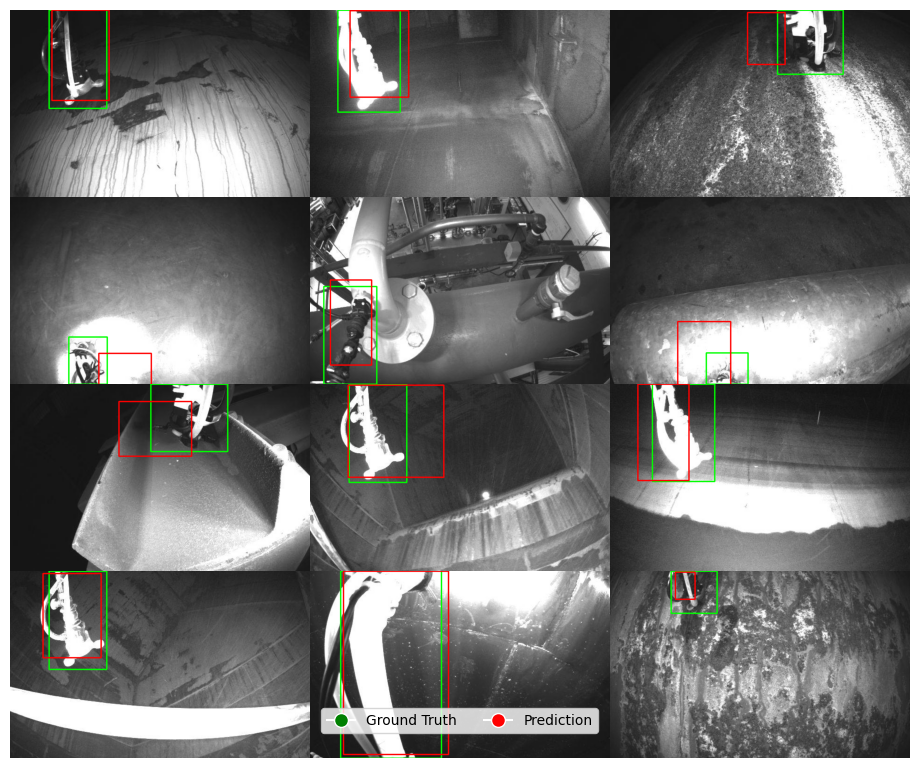

In [70]:
# Plotting

fig, axes = plt.subplots(4, 3, figsize=(9, 7.48), gridspec_kw={'hspace': 0, 'wspace': 0})
for number in range(12):
    image = np.asarray(test_inputs_original).copy()[number]
    target = test_targets_original[number]
    prediction = outputs[number]

    start_point = (int(target[0]), int(target[1]))
    end_point = (int(target[0]) + int(target[2]), int(target[1]) + int(target[3]))

    pred_start_point = (int(prediction[0]), int(prediction[1]))
    pred_end_point = (int(prediction[0]) + int(prediction[2]), int(prediction[1]) + int(prediction[3]))

    if len(image.shape) == 2:  # Grayscale image
        image_with_box = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_with_box = image.copy()

    # Draw the ground truth box in green (thickness 2)
    image_with_box = cv2.rectangle(image_with_box, start_point, end_point, (0, 255, 0), 2)
    # Draw the predicted box in red (thickness 2)
    image_with_box = cv2.rectangle(image_with_box, pred_start_point, pred_end_point, (255, 0, 0), 2)

    row = number // 3
    col = number % 3

    ax = axes[row, col]
    ax.imshow(image_with_box)
    ax.axis("off")

# Add the legend to the plot
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Ground Truth'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Prediction')
]
fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=2)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show(bbox_inches="tight", pad_inches=0)